# Import Package, and Func.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pyscf import gto, scf, fci
import numpy as np
import matplotlib.pyplot as plt
import time
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator, AerProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# To run on hardware, select the backend with the fewest number of jobs in the queue
#service = QiskitRuntimeService(channel="ibm_quantum", token ='55ac54cb4cbfe378d8604606bacfcab38ffd165ecdb215742e64495a259fa53f0ed9e63df5b3df4489d422865a007d9cc981fcb2caffd9e76f17d94d734a8593')
#backend = service.least_busy(operational=True, simulator=False)
#backend = GenericBackendV2(num_qubits=5)

backend = AerSimulator(method = "statevector", noise_model=None)

In [3]:

def fermion_to_qubit(problem, second_q_op, mapper_name,  z2symmetry_reduction=None):
  if mapper_name == "JW":
    mapper = JordanWignerMapper()
  if mapper_name == "Pa":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "BK":
    mapper = BravyiKitaevMapper()

  qubit_op = mapper.map(second_q_op)

  if z2symmetry_reduction != None:
    mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(second_q_op)
  else :
    qubit_op = mapper.map(second_q_op)

  return qubit_op , mapper

def FCI(dist):
    # 1. 분자 정의
    mol = gto.M(
        atom = 'Li 0 0 0; H 0 0 {}'.format(dist),  # 수소 원자 2개, 거리 0.74 Å
        basis = 'sto-3g',              # 간단한 기저함수
        unit = 'Angstrom',
        spin = 0,                      # 전자 수 = 2, 총 spin = 0 (singlet)
        charge = 0
    )

    # 2. Hartree-Fock 계산
    mf = scf.RHF(mol)
    hf_energy = mf.kernel()

    # 3. FCI 계산 (Full CI)
    cisolver = fci.FCI(mol, mf.mo_coeff)
    fci_energy, fci_vector = cisolver.kernel()

    return fci_energy

In [4]:
atoms = ["Li", "H"]
basis = 'sto-3g'
dist = 1.6
coords = [(0,0,0), (dist,0,0)]
charge = 0
multiplicity = 1

H2_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
driver = PySCFDriver.from_molecule(H2_moleculeinfo, basis=basis)
E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 

In [ ]:
fermionic_hamiltonian = E_problem.hamiltonian
second_q_op = fermionic_hamiltonian.second_q_op()
print(second_q_op)
repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
hamiltonian, mapper = fermion_to_qubit(E_problem, second_q_op, "JW", z2symmetry_reduction=None)
num_particles = E_problem.num_particles
num_spatial_orbitals = E_problem.num_spatial_orbitals

init_state = HartreeFock(num_spatial_orbitals,num_particles,mapper)
ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state)


target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
#ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [6]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout) # 그니까 컴파일 된거.
print(hamiltonian_isa)

SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIIZZ', 'IIIIIIIIIYYI', 'IIIIIIIIIYYZ', 'IIIIIIIIIXXI', 'IIIIIIIIIXXZ', 'IIIIIIYZZZYI', 'IIIIIIYZZZYZ', 'IIIIIIXZZZXI', 'IIIIIIXZZZXZ', 'IIIIIIIIIZII', 'IIIIIIIIIZIZ', 'IIIIIIYZZYII', 'IIIIIIYZZYIZ', 'IIIIIIXZZXII', 'IIIIIIXZZXIZ', 'IIIIIIIIZIII', 'IIIIIIIIZIIZ', 'IIIIIIIZIIII', 'IIIIIIIZIIIZ', 'IIIIIIZIIIII', 'IIIIIIZIIIIZ', 'IIIIIZIIIIII', 'IIIIIZIIIIIZ', 'IIIIYYIIIIII', 'IIIIYYIIIIIZ', 'IIIIXXIIIIII', 'IIIIXXIIIIIZ', 'IIIYZYIIIIII', 'IIIYZYIIIIIZ', 'IIIXZXIIIIII', 'IIIXZXIIIIIZ', 'YZZZZYIIIIII', 'YZZZZYIIIIIZ', 'XZZZZXIIIIII', 'XZZZZXIIIIIZ', 'IIIIZIIIIIII', 'IIIIZIIIIIIZ', 'IIIYYIIIIIII', 'IIIYYIIIIIIZ', 'IIIXXIIIIIII', 'IIIXXIIIIIIZ', 'YZZZYIIIIIII', 'YZZZYIIIIIIZ', 'XZZZXIIIIIII', 'XZZZXIIIIIIZ', 'IIIZIIIIIIII', 'IIIZIIIIIIIZ', 'YZZYIIIIIIII', 'YZZYIIIIIIIZ', 'XZZXIIIIIIII', 'XZZXIIIIIIIZ', 'IIZIIIIIIIII', 'IIZIIIIIIIIZ', 'IZIIIIIIIIII', 'IZIIIIIIIIIZ', 'ZIIIIIIIIIII', 'ZIIIIIIIIIIZ', 'IIIIIIIIIYZY', 'IIIIIIII

In [7]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
t_energy_list = []
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    t_0 = time.time()
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    t_1 = time.time()
    t_energy_calc= t_1 - t_0
    t_energy_list.append(t_energy_calc)
    #print("t_energy_calc : " , t_energy_calc)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy




In [8]:
num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [9]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000
    last_time = [time.perf_counter()]   # 리스트로 감싸서 클로저처럼 사용
    iter_times = []
    def timing_callback(xk):
        now = time.perf_counter()
        iter_times.append(now - last_time[0])
        last_time[0] = now
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        callback=timing_callback, 
    )

Iters. done: 1 [Current cost: -5.39425766783352]
Iters. done: 2 [Current cost: -6.494089700206026]
Iters. done: 3 [Current cost: -6.762389633267504]
Iters. done: 4 [Current cost: -6.729206039317144]
Iters. done: 5 [Current cost: -6.722637849887156]
Iters. done: 6 [Current cost: -6.512788133529112]
Iters. done: 7 [Current cost: -5.60914310170719]
Iters. done: 8 [Current cost: -5.105976962393434]
Iters. done: 9 [Current cost: -6.723368147613826]
Iters. done: 10 [Current cost: -6.786564510401061]
Iters. done: 11 [Current cost: -6.932504764559706]
Iters. done: 12 [Current cost: -6.918990108115878]
Iters. done: 13 [Current cost: -6.883918314889212]
Iters. done: 14 [Current cost: -6.99097631318336]
Iters. done: 15 [Current cost: -6.721156453660554]
Iters. done: 16 [Current cost: -6.951975996328975]
Iters. done: 17 [Current cost: -6.9647806592298425]
Iters. done: 18 [Current cost: -6.986972087560683]
Iters. done: 19 [Current cost: -7.204969135831458]
Iters. done: 20 [Current cost: -7.21806344

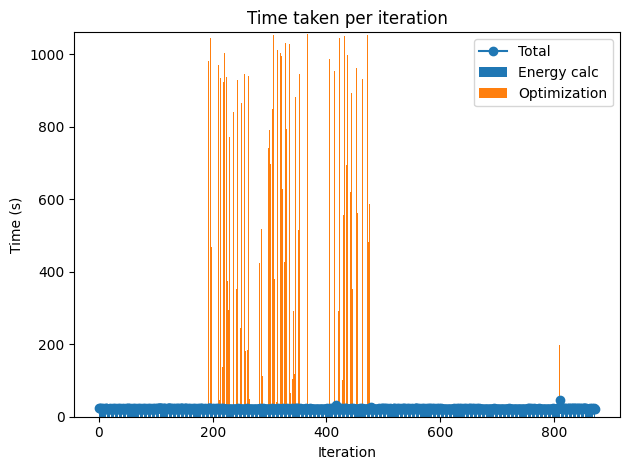

converged SCF energy = -7.86186476980865


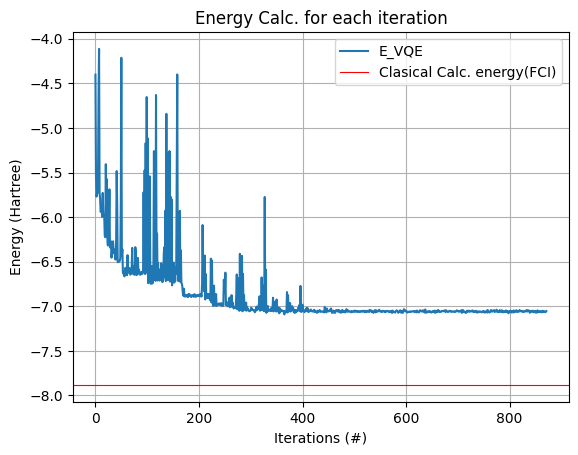

In [10]:
N = len(iter_times)
iterations = np.arange(1, N+1)
energy_time = t_energy_list     # 에너지 계산 예시
total_time  = iter_times     # 최적화 예시
opt_time = []
for k in range(N):
    t_opt = total_time[k] - energy_time[k]
    opt_time.append(t_opt)


plt.figure()
# 스택형 막대
plt.bar(iterations, energy_time,       label='Energy calc')
plt.bar(iterations, opt_time, bottom=energy_time, label='Optimization')
# 총 연산 시간 라인
plt.plot(iterations, total_time, marker='o', label='Total')

plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Time taken per iteration')
plt.legend()
plt.tight_layout()
plt.show()

E_exact = FCI(dist)


plt.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"] + repulsion, label='E_VQE')
plt.axhline(E_exact, color = 'r', linewidth = 0.8, label = 'Clasical Calc. energy(FCI)')
plt.xlabel("Iterations (#)")
plt.ylabel("Energy (Hartree)")
plt.title("Energy Calc. for each iteration")
plt.legend()
plt.grid()
plt.draw()

In [11]:
print(opt_time)
print(energy_time)

[0.000749470666050911, 3.15094948746264e-05, -5.584291648119688e-05, -3.315630601719022e-05, -1.7979706171900034e-05, -3.621482755988836e-05, 5.9434096328914165e-06, 9.019917342811823e-06, -5.4046278819441795e-05, 7.371034007519484e-05, 1.149915624409914e-05, -4.34432877227664e-05, 1.7198966816067696e-05, -1.0820978786796331e-05, 7.049500709399581e-05, -2.0207604393363e-05, -3.5957200452685356e-05, -5.22495829500258e-05, -2.5090528652071953e-05, -4.294427344575524e-05, -4.3843931052833796e-05, -5.246617365628481e-05, 9.67656378634274e-05, 4.0484650526195765e-05, -1.9214756321161985e-05, -4.527677083387971e-05, -4.63049509562552e-05, -2.2816413547843695e-05, -4.3320993427187204e-05, -4.472112050279975e-05, 5.732738645747304e-05, -2.878718078136444e-06, -1.351628452539444e-05, -4.3760810513049364e-05, -4.6808330807834864e-05, -5.598511779680848e-05, -2.695049624890089e-05, -4.6945991925895214e-05, -5.23001654073596e-05, -4.4427288230508566e-05, -4.9159047193825245e-05, -5.961983697488904

In [14]:
print(np.sum(total_time))
print(np.sum(energy_time))

19546.784488709003
95086.14105892181
